In [4]:
import sys
import os

In [5]:
sys.path.append(os.path.abspath("../src"))

In [317]:
import cv2
from matplotlib import pyplot as plt
import base64
import pandas as pd

In [105]:
from utils import align_to_template

In [402]:
image = cv2.imread("/Users/volpea/Documents/projects/document-generator-job/data/test/example_form_real_2.jpg")
template = cv2.imread("/Users/volpea/Documents/projects/document-generator-text-extractor/data/templates/example_form_template.webp")

In [403]:
registered_image = align_to_template(image, template)
registered_image = cv2.cvtColor(registered_image, cv2.COLOR_BGR2RGB)
success, encoded_image = cv2.imencode('.png', registered_image)
base64_image = base64.b64encode(encoded_image).decode('utf-8')

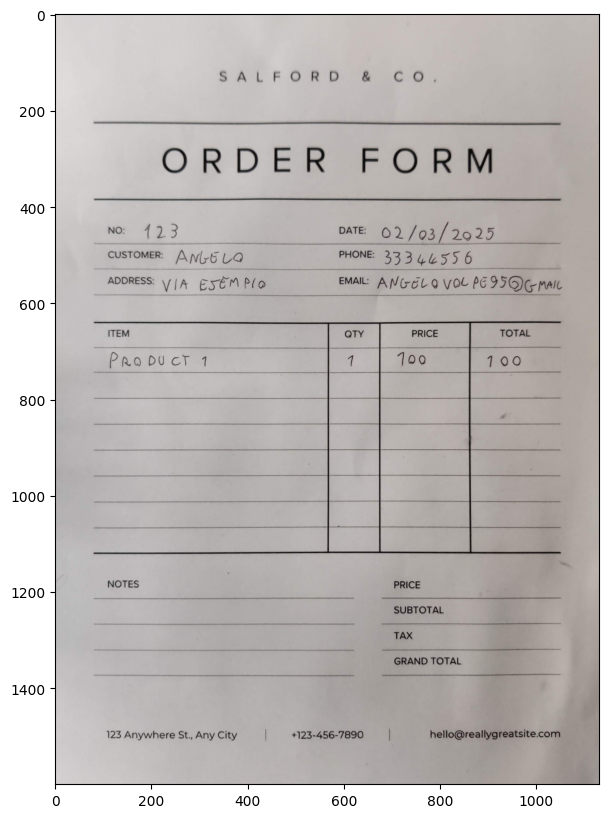

In [404]:
plt.figure(figsize=(20, 10))
plt.imshow(registered_image)
plt.show()

In [405]:
import requests

# URL of your API endpoint
url = "http://localhost:5001/predict"

In [409]:
response = requests.post(url, 
                         json={"image": base64_image})

In [410]:
response.status_code

200

In [411]:
predictions = response.json()["predictions"]

In [412]:
predictions.keys()

dict_keys(['class', 'original_box', 'predicted_text', 'score', 'text_score'])

In [413]:
df = pd.DataFrame(predictions)

In [414]:
df

,class,original_box,predicted_text,score,text_score
0,2,"[663, 437, 934, 476]",02/03/2025,0.991953,0.957668
1,9,"[661, 539, 1037, 579]",ANGOLOVOLPE95QGMA,0.991645,0.767817
2,10,"[207, 543, 444, 579]",VIA ESEMPIO,0.989358,0.891797
3,8,"[698, 696, 775, 735]",100,0.989219,0.930381
4,1,"[99, 702, 323, 735]",PRQDUCT1,0.984809,0.819011
5,6,"[235, 487, 406, 522]",ANGELO,0.981977,0.776385
6,5,"[176, 430, 263, 470]",123,0.959472,0.997880
7,4,"[887, 703, 981, 738]",100,0.883455,0.996998
8,3,"[599, 700, 634, 736]",1,0.592927,0.802397
11,7,"[672, 492, 871, 529]",33344556,0.277597,0.994826


### TrOCR

In [356]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
# microsoft/trocr-base-handwritten
# microsoft/trocr-large-handwritten
# microsoft/trocr-base-printed

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-printed")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_

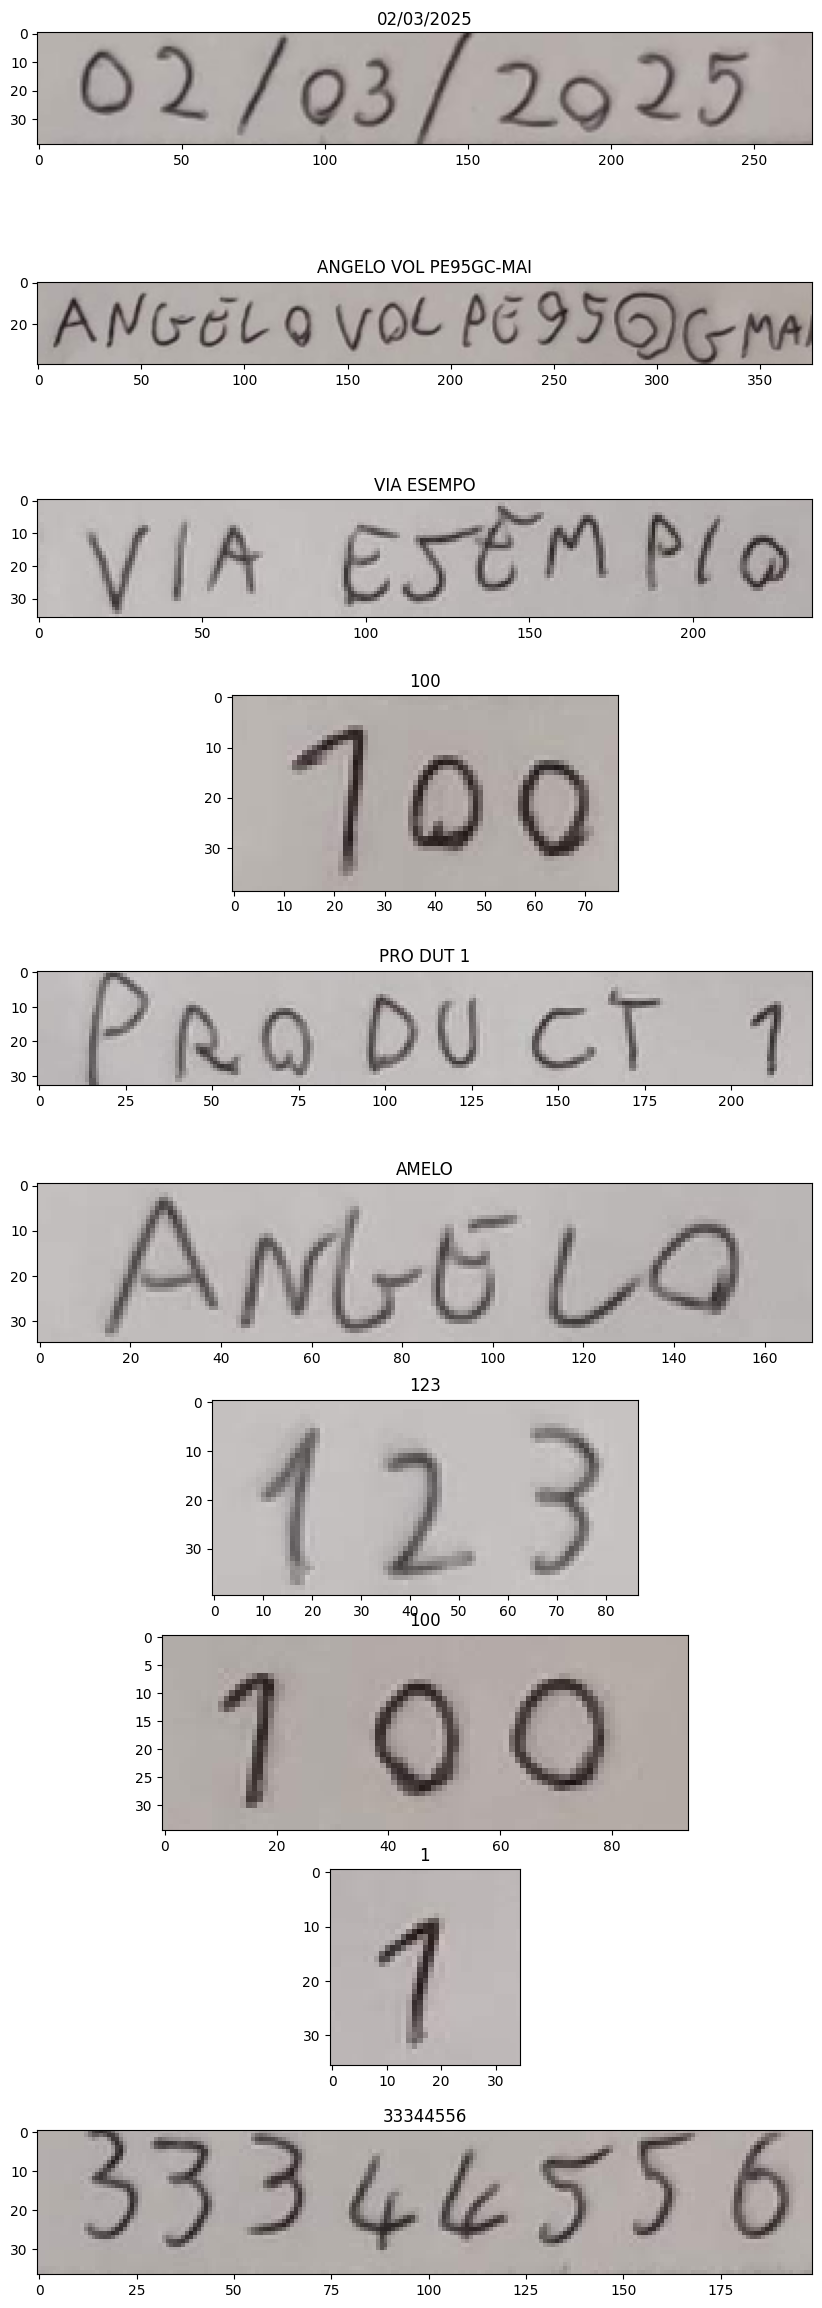

In [ ]:
fig, ax = plt.subplots(nrows=len(df), figsize=(10,30))

for i, box in enumerate(df["original_box"]):
    box_image = registered_image[box[1]:box[3], box[0]:box[2]]
    ax[i].imshow(box_image)
    
    pixel_values = processor(box_image, return_tensors="pt").pixel_values

    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    ax[i].set_title(generated_text)

### Pytesseract

In [359]:
import pytesseract

In [ ]:
def pre_process_image(image):
    """This function will pre-process a image with: cv2 & deskew
    so it can be process by tesseract"""
    img = cv2.imread(image)
    img = cv2.resize(img, None, fx=.3, fy=.3) #resize using percentage
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #change color format from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #format image to gray scale
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 11) #to remove background
    return img

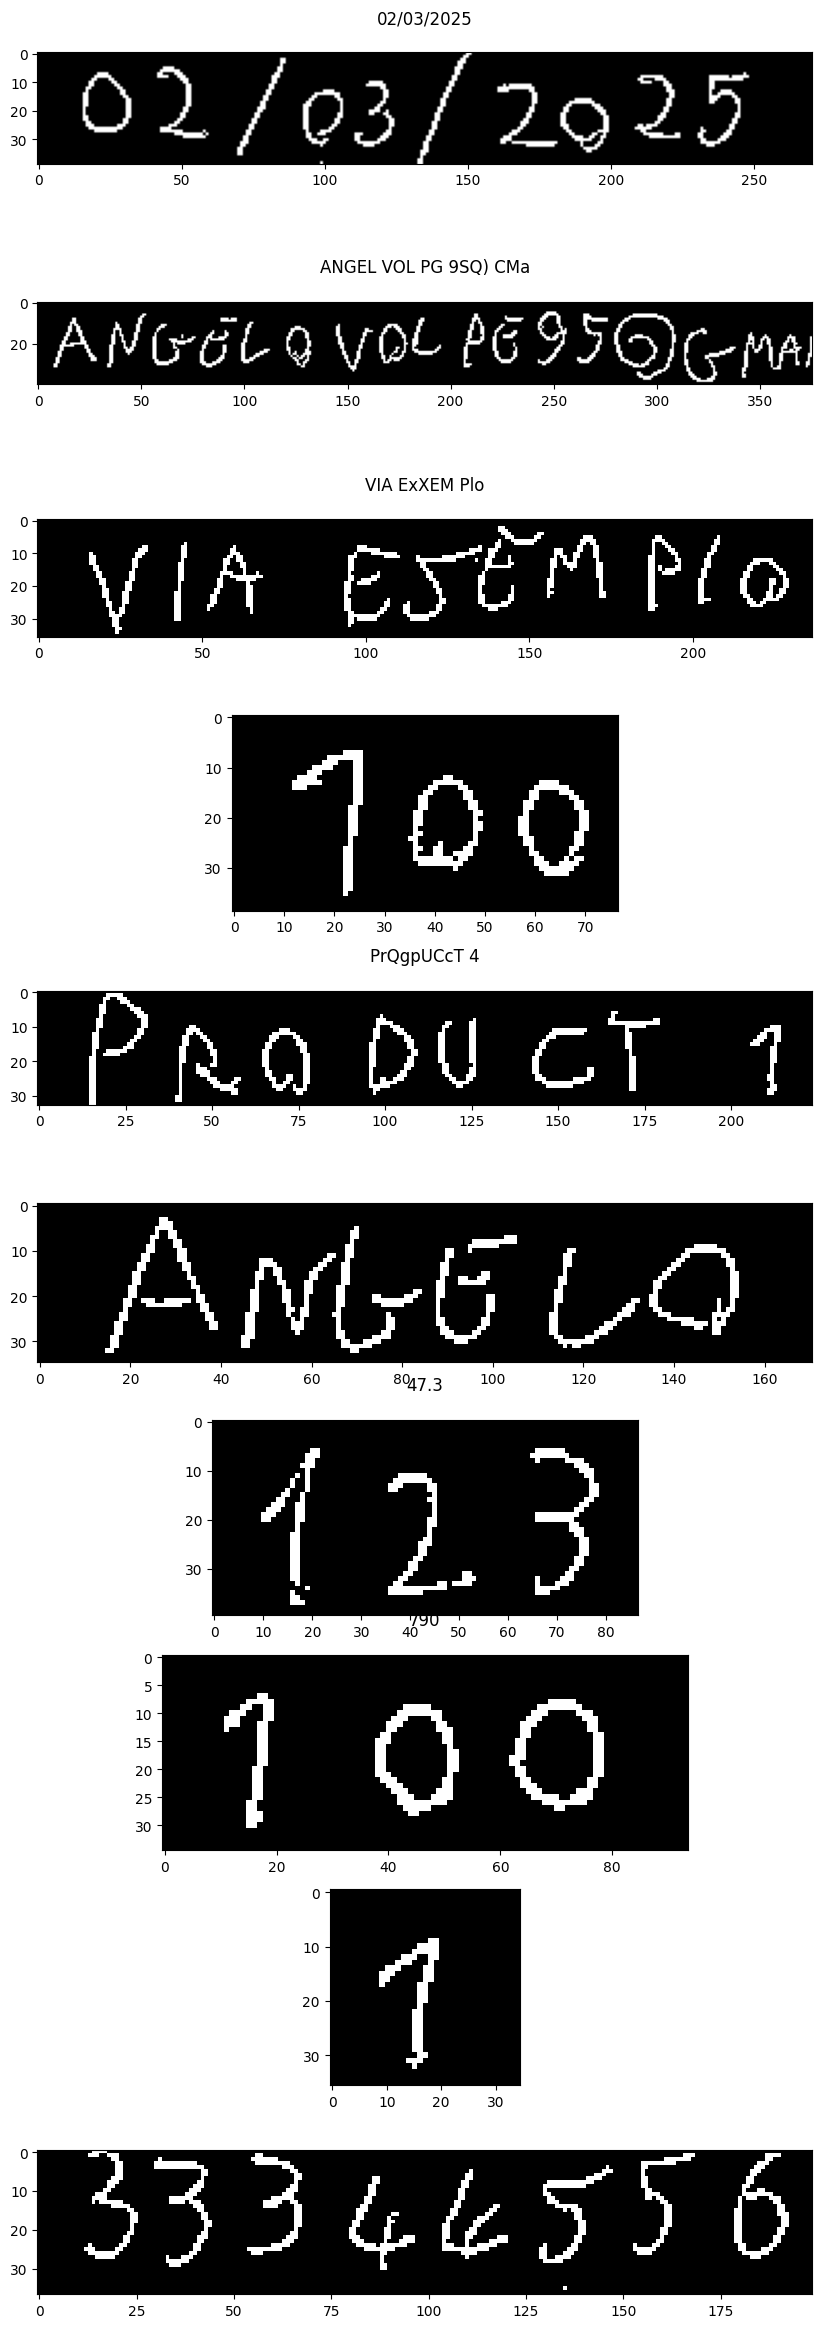

In [368]:
fig, ax = plt.subplots(nrows=len(df), figsize=(10,30))

for i, box in enumerate(df["original_box"]):
    box_image = registered_image[box[1]:box[3], box[0]:box[2]]
    box_image = cv2.cvtColor(box_image, cv2.COLOR_RGB2GRAY)
    box_image = cv2.adaptiveThreshold(box_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 11)
    ax[i].imshow(box_image, cmap="binary")
    
    predicted_string = pytesseract.image_to_string(box_image)
    ax[i].set_title(predicted_string)

### PaddleOCR

In [389]:
pip install paddleocr==2.10.0

  Using cached pyclipper-1.3.0.post6-cp312-cp312-macosx_10_13_universal2.whl.metadata (9.0 kB)
  Using cached lmdb-1.6.2-cp312-cp312-macosx_10_13_universal2.whl.metadata (1.1 kB)
  Using cached python_docx-1.1.2-py3-none-any.whl.metadata (2.0 kB)
  Using cached fire-0.7.0-py3-none-any.whl
  Using cached soupsieve-2.6-py3-none-any.whl.metadata (4.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.7 MB/s eta 0:00:00
Using cached lmdb-1.6.2-cp312-cp312-macosx_10_13_universal2.whl (166 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 38.0 MB/s eta 0:00:00a 0:00:01
Using cached pyclipper-1.3.0.post6-cp312-cp312-macosx_10_13_universal2.whl (270 kB)
Using cached python_docx-1.1.2-py3-none-any.whl (244 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.

In [393]:
from paddleocr import PaddleOCR

/Users/volpea/Documents/projects/document-generator-text-extractor/.venv/lib/python3.12/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [394]:
ocr = PaddleOCR(use_angle_cls=True, lang='en', det=False, rec=True, use_gpu=False)

[2025/04/20 14:11:35] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/volpea/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/volpea/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_n

In [401]:
pip show paddlepaddle

Name: paddlepaddle
Version: 3.0.0
Summary: Parallel Distributed Deep Learning
Home-page: https://www.paddlepaddle.org.cn/
Author: 
Author-email: Paddle-better@baidu.com
License: Apache Software License
Location: /Users/volpea/Documents/projects/document-generator-text-extractor/.venv/lib/python3.12/site-packages
Requires: astor, decorator, httpx, networkx, numpy, opt-einsum, Pillow, protobuf, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


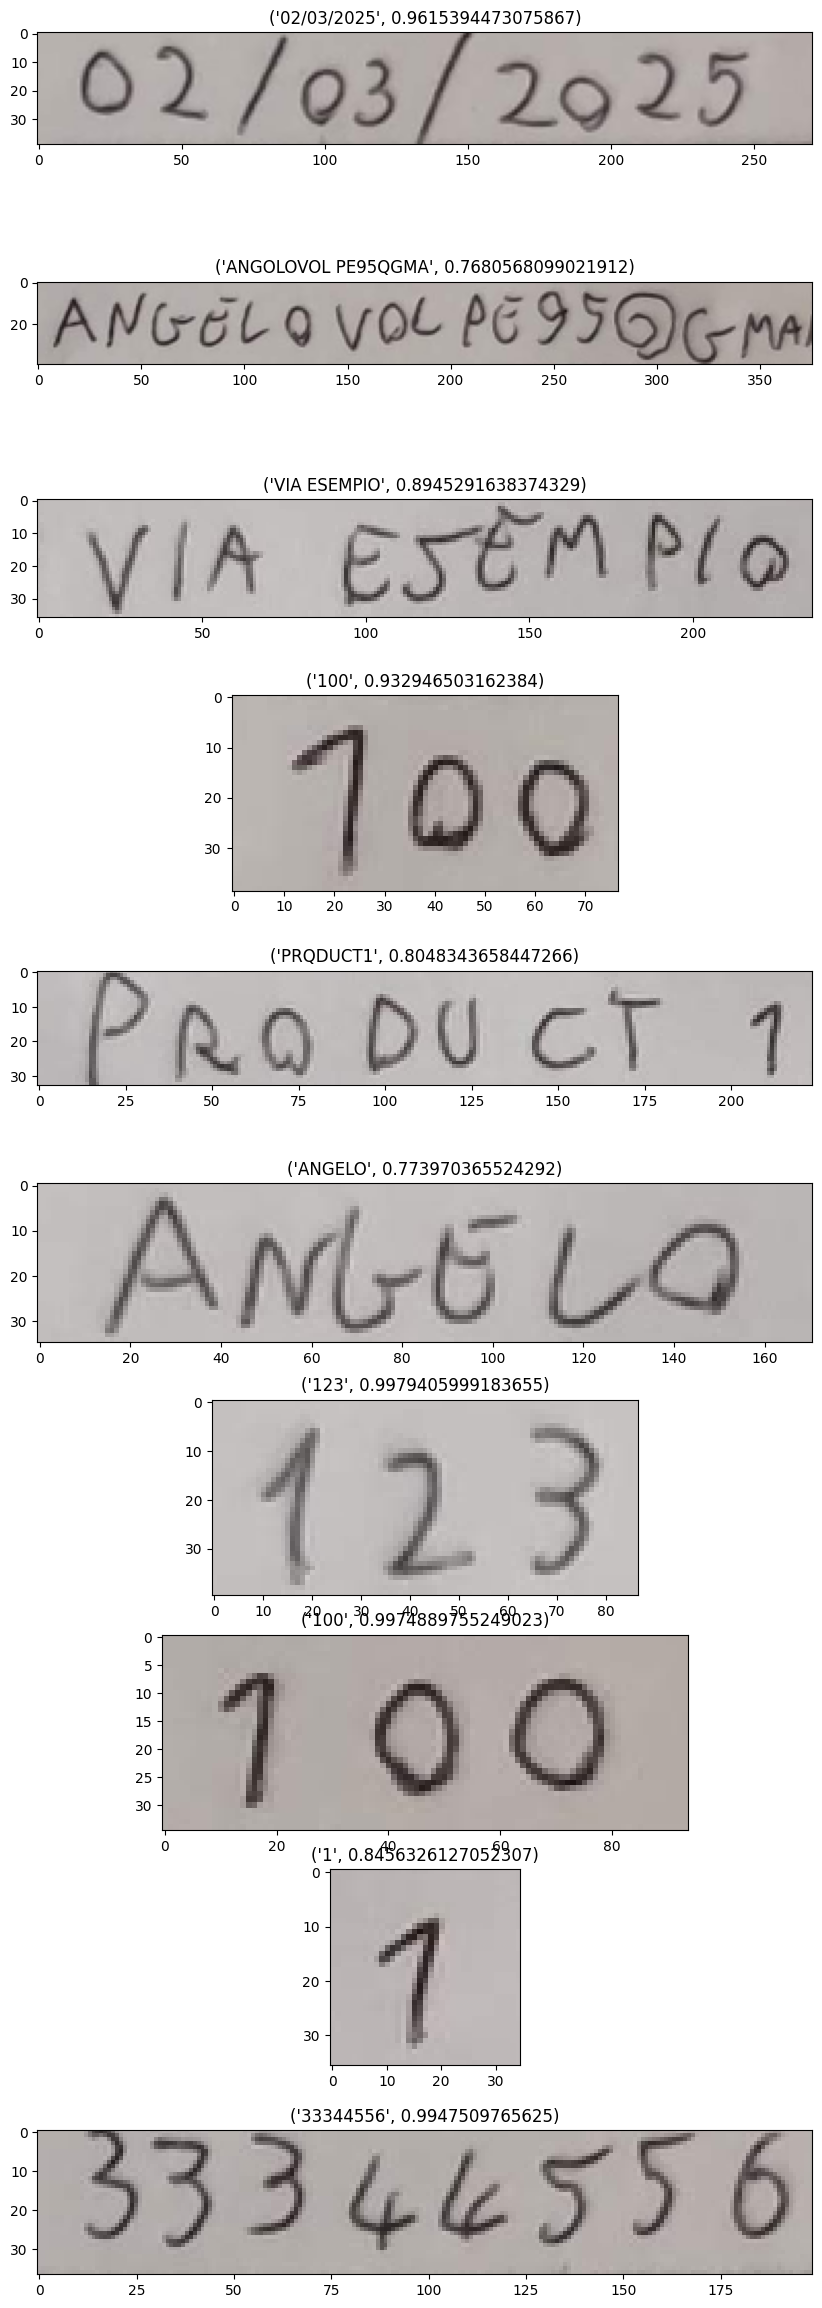

In [400]:
fig, ax = plt.subplots(nrows=len(df), figsize=(10,30))

for i, box in enumerate(df["original_box"]):
    box_image = registered_image[box[1]:box[3], box[0]:box[2]]
    ax[i].imshow(box_image, cmap="binary")
    
    predicted_string = ocr.ocr(box_image, det=False)[0][0]
    ax[i].set_title(predicted_string)